In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pickle
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import seaborn as sns
%matplotlib inline
import numpy as np
import warnings
import copy
warnings.filterwarnings('ignore')
import re
import ast

In [2]:
data = pd.read_csv('data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [3]:
print(data.columns)

Index(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds',
       'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target'],
      dtype='object')


In [4]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data)

               Total   Percent
private pool  373004  0.988915
mls-id        352243  0.933873
PrivatePool   336874  0.893127
fireplace     274070  0.726620
stories       150715  0.399578
baths         106338  0.281925
beds           91282  0.242009
MlsId          66880  0.177314
sqft           40577  0.107579
status         39918  0.105831
propertyType   34733  0.092085
target          2481  0.006578
city              34  0.000090
street             2  0.000005
homeFacts          0  0.000000
zipcode            0  0.000000
state              0  0.000000
schools            0  0.000000


In [5]:
# Функции и списки для обработки данных
top = ['WA', 'NH', 'MN', 'UT', 'VT', 'MD', 'VA', 'MA', 'NE', 'CO', 'WI', 'NJ', 'FL', 'IA', 'ND', 'ID']
mid = ['GA', 'NC', 'CA', 'SD', 'CT', 'KS', 'DE', 'HI', 'NY', 'RI', 'OR', 'MO', 'MT', 'TN', 'WY', 'ME']
    
data = data.drop(['MlsId', 'mls-id', 'private pool', 'status', 'propertyType'],axis = 1)
def state(x):
    if x in top:
        return 2
    if x in mid:
        return 1
    return 0
    
def func_cool(x):
    if x == '':
        return 0
    return 1

def func_pool(x):
    if type(x) != int:
        x = x.replace(x, '1')
    return int(x)
    
def func_stor(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if (len(x) > 1):
            x = x[0]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return 1
    return x
    
def func_cost(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 2:
            x = x[0] + x[1] + x[2]
        elif len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)
    
def func_area(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)

def func_lot(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)
    
def func_built(x):
    x = re.findall(r'\d+',x)
    if len(x) > 1:
        x = x[0] + x[1]
    elif len(x) == 1:
        x = x[0]
    if not x:
        return np.nan
    return int(x)
        
def data_func1(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][0].get('factValue')

def data_func2(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][1].get('factValue')

def data_func3(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][2].get('factValue')

def data_func4(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][3].get('factValue')

def data_func5(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][4].get('factValue')

def data_func6(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][5].get('factValue')
    
def data_func8(x):
    m = []
    a = ast.literal_eval(x)
    a = dict(a[0])
    k = a['data'].get('Distance')
    for i in k:
        h = re.findall(r'\d+',i)
        if len(h) == 0:
            continue
        if len(h) == 1:
            m.append(float(h[0]))
            continue
        d = h[0] + '.' + h[1]
        m.append(float(d))
    if len(m) == 0:
        return np.nan
    else:
        return min(m)
    
def func_rebuilt(row):
    if row['rebuilt'] == 0:
        return row['built']
    if row['rebuilt'] == '':
        return row['built']
    return row['rebuilt']
 
# Обработка данных: удаляю все строки с пропущенными значениями, где тяжело заменить nan
data['PrivatePool'] = data['PrivatePool'].fillna(0).apply(func_pool)
data['fireplace'] = data['fireplace'].fillna(0).apply(func_pool)
data['baths'] = data['baths'].fillna(0).apply(func_stor)
data['stories'] = data['stories'].fillna(0).apply(func_stor)
data['beds'] = data['beds'].fillna(0).apply(func_stor)
data['built'] = data['homeFacts'].apply(data_func1)
data['rebuilt'] = data['homeFacts'].apply(data_func2)
data['heating'] = data['homeFacts'].apply(data_func3)
data['cooling'] = data['homeFacts'].apply(data_func4)
data['parking'] = data['homeFacts'].apply(data_func5)
data['lotsize'] = data['homeFacts'].apply(data_func6)
data['distance'] = data['schools'].apply(data_func8)
data = data.drop(['homeFacts', 'schools'], axis = 1)
data['cooling'] = data['cooling'].apply(func_cool)
data['heating'] = data['heating'].apply(func_cool)
data['parking'] = data['parking'].apply(func_cool)
data['state'] = data['state'].apply(state)
data = data.drop(data.loc[data['lotsize'].isnull()].index)
data['lotsize'] = data['lotsize'].apply(func_lot)
data = data.drop(data.loc[data['lotsize'].isnull()].index)
data = data.drop(data.loc[data['built'].isnull()].index)
data['built'] = data['built'].apply(func_built)
data = data.drop(data.loc[data['built'].isnull()].index)
data = data.drop(data.loc[data['target'].isnull()].index)
data = data.drop(data.loc[data['sqft'].isnull()].index)
data['sqft'] = data['sqft'].apply(func_area)
data['target'] = data['target'].apply(func_cost)
data = data.drop(data.loc[data['target'].isnull()].index)
data = data.drop(data.loc[data['sqft'].isnull()].index)
data['rebuilt'] = data['rebuilt'].fillna(0)
data = data.drop(data.loc[data['distance'].isnull()].index)
data = data.drop(data.loc[data['city'].isnull()].index)
data = data.drop(data.loc[data['street'].isnull()].index)
data['rebuilt'] = data.apply(lambda row: func_rebuilt(row), axis=1)
data['built'] = data['built'].astype(int)
data['rebuilt'] = data['rebuilt'].astype(int)
data['lotsize'] = data['lotsize'].astype(int)
data['sqft'] = data['sqft'].astype(int)
data['baths'] = data['baths'].astype(int)
data['beds'] = data['beds'].astype(int)
data['stories'] = data['stories'].astype(int)
data.to_csv('obr1.csv', index=False)

In [38]:
data = pd.read_csv('obr1.csv')

In [39]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = data.columns.values.tolist()
for col in features:
    if data[col].dtype in numerics: continue
    categorical_columns.append(col)
for col in categorical_columns:
    if col in data.columns:
        le = LabelEncoder()
        le.fit(list(data[col].astype(str).values))
        data[col] = le.transform(list(data[col].astype(str).values))

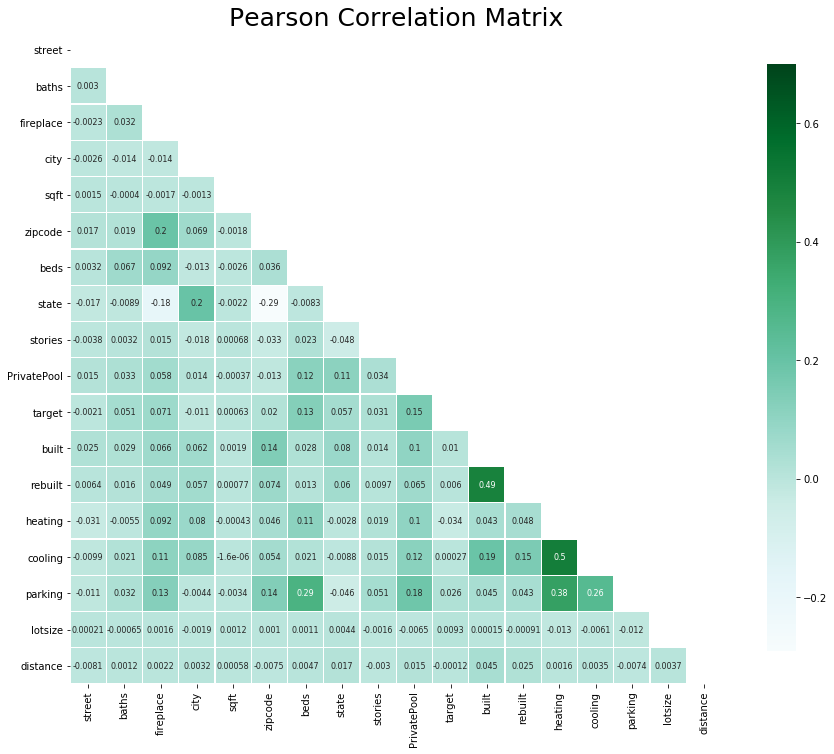

In [40]:
#Матрица корелляций для лучшего понимания данных
mask = np.zeros_like(data[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(data[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn",
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

In [41]:
# Перцентили для очистки данных (удаляю все что меньше 2% и больше 98%)
data.describe(percentiles=[.01, .02, .03, .05, .1, .5, .9, .92, .94, .98, .99])

,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,target,built,rebuilt,heating,cooling,parking,lotsize,distance
count,236708.000000,236708.000000,236708.000000,236708.000000,2.367080e+05,236708.000000,236708.000000,236708.000000,236708.000000,236708.000000,2.367080e+05,236708.000000,236708.000000,236708.000000,236708.000000,236708.000000,2.367080e+05,236708.000000
mean,104120.622979,2.451675,0.384343,817.652572,4.938856e+03,2023.169399,2.961919,0.936859,1.229312,0.116274,6.308320e+05,1976.454636,1980.108370,0.850123,0.806838,0.663953,1.637704e+04,1.079466
std,60090.215675,11.639927,0.486441,440.983062,9.386034e+05,1044.892333,2.403597,0.856899,3.524141,0.320554,1.637491e+06,34.303614,57.081108,0.356951,0.394780,0.472356,7.278628e+05,6.532286
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000
1%,1978.070000,0.000000,0.000000,50.070000,5.700000e+02,101.000000,0.000000,0.000000,0.000000,0.000000,2.400000e+04,1897.000000,1900.000000,0.000000,0.000000,0.000000,3.000000e+00,0.100000
2%,4064.140000,0.000000,0.000000,66.000000,7.070000e+02,164.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+04,1900.000000,1905.000000,0.000000,0.000000,0.000000,6.000000e+00,0.100000
3%,6131.210000,0.000000,0.000000,71.000000,7.800000e+02,189.000000,0.000000,0.000000,0.000000,0.000000,5.500000e+04,1909.000000,1911.000000,0.000000,0.000000,0.000000,2.500000e+01,0.100000
5%,10308.350000,0.000000,0.000000,134.000000,8.850000e+02,285.000000,0.000000,0.000000,0.000000,0.000000,7.990000e+04,1916.000000,1920.000000,0.000000,0.000000,0.000000,2.700000e+01,0.140000
10%,20751.700000,0.000000,0.000000,261.000000,1.051000e+03,765.000000,0.000000,0.000000,0.000000,0.000000,1.272590e+05,1925.000000,1931.000000,0.000000,0.000000,0.000000,3.400000e+01,0.200000
50%,104379.500000,2.000000,0.000000,770.000000,1.943000e+03,1808.000000,3.000000,1.000000,1.000000,0.000000,3.389995e+05,1982.000000,1988.000000,1.000000,1.000000,1.000000,5.000000e+03,0.600000


In [46]:
data = data[data['street'] >= 4000]
data = data[data['city'] > 66]
data = data[data['zipcode'] > 160]
data = data[data['sqft'] < 7000]
data = data[data['baths'] <= 8]
data = data[data['beds'] <= 7]
data = data[data['stories'] <= 6]
data = data[data['target'] <= 3500000]
data = data[data['built'] < 2020]
data = data[data['rebuilt'] < 2020]
data = data[data['lotsize'] <= 40000]
data = data[data['distance'] < 7]
data = data[data['built'] >= 1900]
data = data[data['rebuilt'] >= 1900]
data = data[data['sqft'] >= 220]
data = data[data['lotsize'] >= 6]
data = data[data['target'] >= 40000]
data = data[data['beds'] >= 1]
data['area'] = data['sqft'] + data['lotsize']

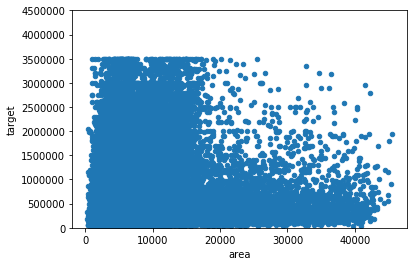

In [47]:
#Из графика видно, что в данных есть как квартиры(область до 20000 площади) так и земельные участки
var = 'area'
dat = pd.concat([data['target'], data[var]], axis=1)
dat.plot.scatter(x=var, y='target', ylim=(0,4500000));

In [11]:
# Обучение модели для первичного Feature Selection
train_fe = copy.deepcopy(data)
target_fe = train_fe['target']
del train_fe['target']
X = train_fe
z = target_fe
Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state=21)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,        
    }

modelL = lgb.train(params, train_set = train_set, num_boost_round=1000,
                   early_stopping_rounds=50,verbose_eval=100, valid_sets=valid_set)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 242708
[200]	valid_0's rmse: 223272
[300]	valid_0's rmse: 215239
[400]	valid_0's rmse: 210432
[500]	valid_0's rmse: 206867
[600]	valid_0's rmse: 204107
[700]	valid_0's rmse: 201830
[800]	valid_0's rmse: 199600
[900]	valid_0's rmse: 197954
[1000]	valid_0's rmse: 196227
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 196227


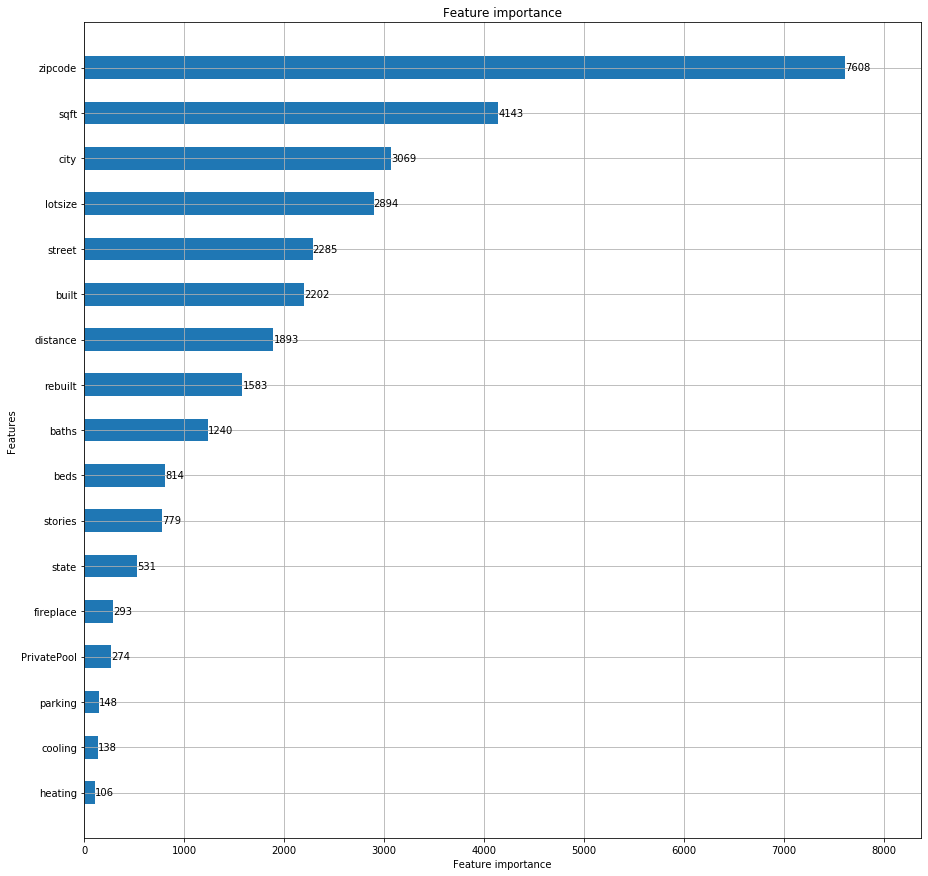

In [12]:
# График важности признаков
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();plt.close()

In [13]:
# Запись важности признаков в отдельный DataFrame
feature_score = pd.DataFrame(train_fe.columns, columns = ['feature']) 
feature_score['score_lgb'] = modelL.feature_importance()

In [14]:
# Feature selection для XGBoost
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xval   , label=Zval)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:squarederror',
         'eta'      :0.3,
         'subsample':0.8,
         'lambda '  :4, 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10}
modelx = xgb.train(parms, data_tr, num_boost_round=200, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=50)

print('score = %1.5f, n_boost_round =%d.'%(modelx.best_score,modelx.best_iteration))

[20:01:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:503503.43750	valid-rmse:510492.90625
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:171264.46875	valid-rmse:206769.82812
[100]	train-rmse:149829.65625	valid-rmse:198194.17188
[150]	train-rmse:135131.20312	valid-rmse:192991.32812
[199]	train-rmse:123159.32031	valid-rmse:190749.75000
score = 190749.75000, n_boost_round =199.


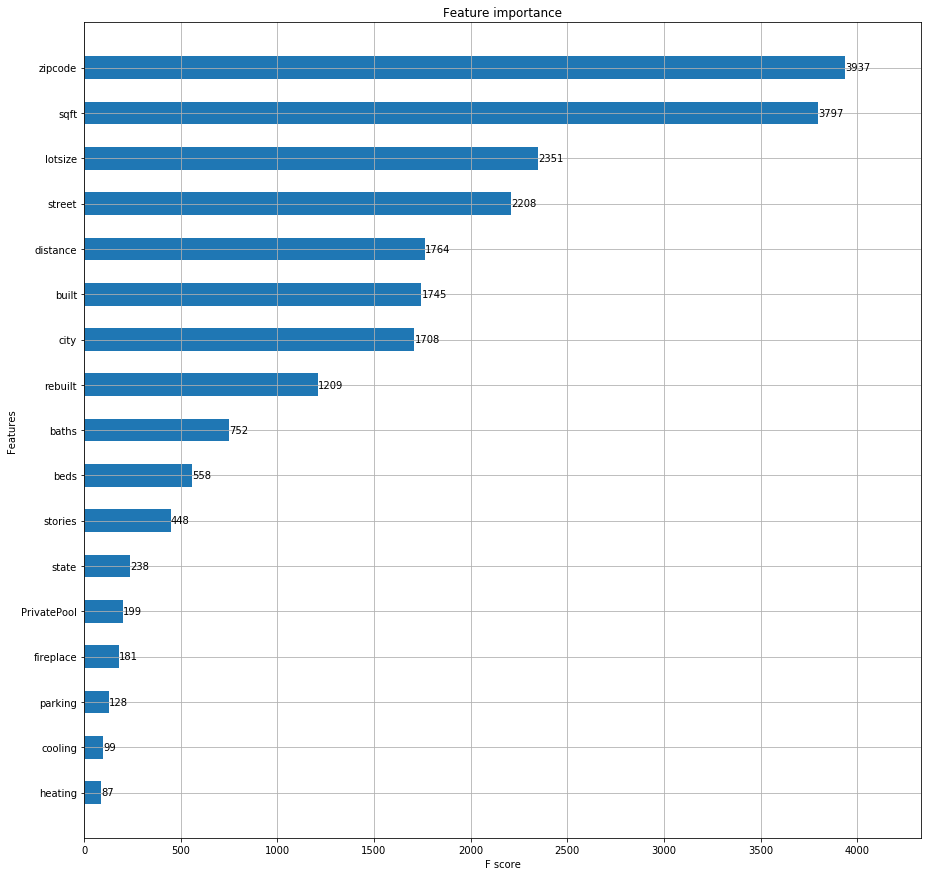

In [15]:
# Важность признаков для XGBoost
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(modelx,ax = axes,height = 0.5)
plt.show();plt.close()

In [16]:
# Запись результатов
feature_score['score_xgb'] = feature_score['feature'].map(modelx.get_score(importance_type='weight'))
feature_score

,feature,score_lgb,score_xgb
0,street,2285,2208
1,baths,1240,752
2,fireplace,293,181
3,city,3069,1708
4,sqft,4143,3797
5,zipcode,7608,3937
6,beds,814,558
7,state,531,238
8,stories,779,448
9,PrivatePool,274,199


In [17]:
# Feature selection для LinearRegression
linreg = LinearRegression()
linreg.fit(train_fe, target_fe)
coeff_linreg = pd.DataFrame(train_fe.columns.delete(0))
coeff_linreg.columns = ['feature']
coeff_linreg["score_linreg"] = pd.Series(linreg.coef_)
coeff_linreg.sort_values(by='score_linreg', ascending=False)

,feature,score_linreg
1,fireplace,99950.195804
7,stories,96763.569524
9,built,86313.923147
14,lotsize,39381.632619
4,zipcode,220.424383
5,beds,61.498267
0,baths,-0.093010
15,distance,-3.685079
3,sqft,-11.471599
11,heating,-1360.959517


In [18]:
# Запись в dataframe
coeff_linreg["score_linreg"] = coeff_linreg["score_linreg"].abs().astype(int)
feature_score = pd.merge(feature_score, coeff_linreg, on='feature')
feature_score = feature_score.fillna(0)
feature_score = feature_score.set_index('feature')

# Итоговые значения
feature_score

,score_lgb,score_xgb,score_linreg
feature,,,
baths,1240,752,0
fireplace,293,181,99950
city,3069,1708,15935
sqft,4143,3797,11
zipcode,7608,3937,220
beds,814,558,61
state,531,238,48115
stories,779,448,96763
PrivatePool,274,199,2218


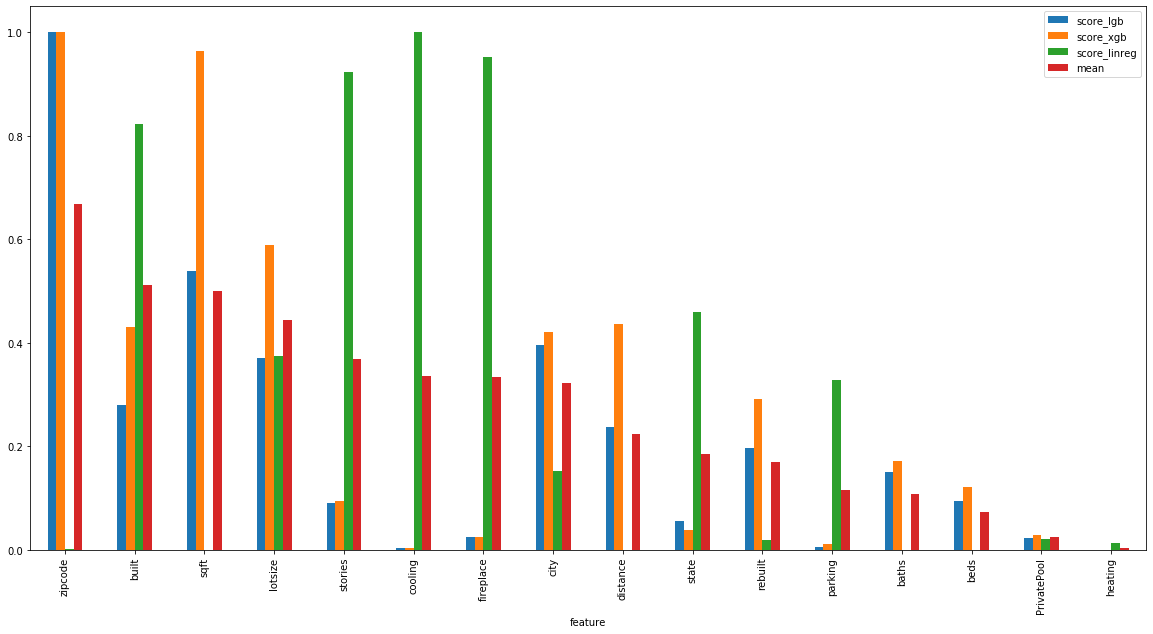

In [19]:
# Сравнение важности признаков каждой модели
feature_score = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(feature_score),
    columns=feature_score.columns,
    index=feature_score.index
)

feature_score['mean'] = feature_score.mean(axis=1)

feature_score.sort_values('mean', ascending=False).plot(kind='bar', figsize=(20, 10))

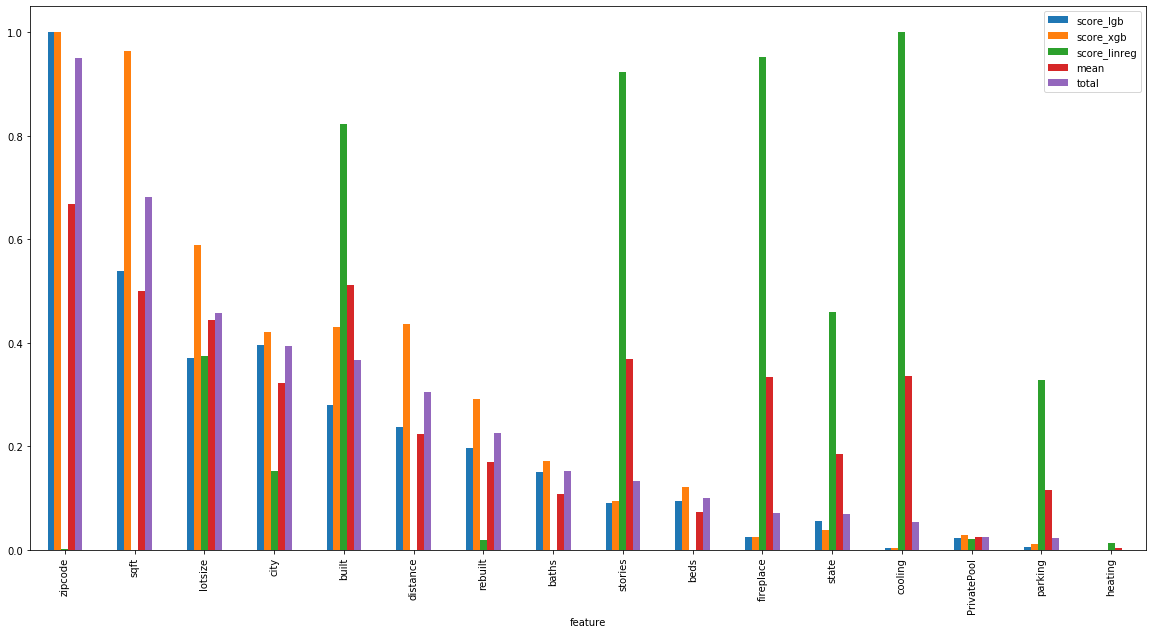

In [20]:
# Важность признаков с учетом весов
feature_score['total'] = 0.55*feature_score['score_lgb'] + 0.4*feature_score['score_xgb'] \
                       + 0.05*feature_score['score_linreg']

feature_score.sort_values('total', ascending=False).plot(kind='bar', figsize=(20, 10))

In [21]:
feature_score.sort_values('total', ascending=False)
# Финальный результат

,score_lgb,score_xgb,score_linreg,mean,total
feature,,,,,
zipcode,1.000000,1.000000,0.002098,0.667366,0.950105
sqft,0.538123,0.963636,0.000105,0.500621,0.681428
lotsize,0.371634,0.588052,0.375468,0.445052,0.458393
city,0.394961,0.421039,0.151928,0.322643,0.393241
built,0.279392,0.430649,0.822930,0.510990,0.367072
distance,0.238203,0.435584,0.000029,0.224605,0.305247
rebuilt,0.196881,0.291429,0.019440,0.169250,0.225828
baths,0.151160,0.172727,0.000000,0.107962,0.152229
stories,0.089709,0.093766,0.922563,0.368679,0.132975


In [22]:
# Отбросим 6 хужших признаков и rebuilt, который сильно коррелирует с built
data = data.drop(['heating', 'parking', 'PrivatePool', 'cooling', 'fireplace', 'state', 'rebuilt'], axis = 1)

In [23]:
# Разделение выборки для тренировки модели
valid_part = 0.3
target_name = 'target'
train_target0 = data[target_name]
train0 = data.drop([target_name], axis=1)
train0, test0, train_target0, test_target0 = train_test_split(train0, train_target0, test_size=0.2, random_state=0)
train0b = train0
train_target0b = train_target0
trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size=valid_part, random_state=0)
train, test, target, target_test = train_test_split(train0, train_target0, test_size=valid_part, random_state=0)

In [24]:
# Создание функций для отображения разных метрик и занесения результатов в dataframe
acc_train_r2 = []
acc_test_r2 = []
acc_train_rmse = []
acc_test_rmse = []
acc_train_mape = []
acc_test_mape = []

def acc_d(y_meas, y_pred):
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    return (mean_squared_error(y_meas, y_pred))**0.5

def acc_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Для boosting моделей
def acc_boosting_model(num,model,train,test,num_iteration=0):
    global acc_train_r2, acc_test_r2, acc_train_rmse, acc_test_rmse, acc_train_mape, acc_test_mape
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', targetb[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(targetb, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)
    
    acc_train_mape_num = round(acc_mape(targetb, ytrain) * 100, 2)
    print('acc(mape) for train =', acc_train_mape_num)   
    acc_train_mape.insert(num, acc_train_mape_num)

    acc_train_rmse_num = round(acc_rmse(targetb, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_testb[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_testb, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)

    acc_test_mape_num = round(acc_mape(target_testb, ytest) * 100, 2)
    print('acc(mape) for test =', acc_test_mape_num)   
    acc_test_mape.insert(num, acc_test_mape_num)
    
    acc_test_rmse_num = round(acc_rmse(target_testb, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [25]:
# Для остальных моделей
def acc_model(num,model,train,test):  
  
    global acc_train_r2, acc_test_r2, acc_train_rmse, acc_test_rmse, acc_train_mape, acc_test_mape
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)
    
    acc_train_mape_num = round(acc_mape(target, ytrain) * 100, 2)
    print('acc(mape) for train =', acc_train_mape_num)   
    acc_train_mape.insert(num, acc_train_mape_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_mape_num = round(acc_mape(target_test, ytest) * 100, 2)
    print('acc(mape) for test =', acc_test_mape_num)
    acc_test_mape.insert(num, acc_test_mape_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [26]:
# Проверка на точность randomforest
random_forest = RandomForestRegressor(n_estimators = 300, max_depth = 7, random_state = 21)
random_forest.fit(train, target)
acc_model(1,random_forest,train,test)

target =  [270000 309990 319900 449000 258800]
ytrain =  [ 425853.23311739  264708.65619815  482432.71803918 1234081.03289924
  616850.895173  ]
acc(r2_score) for train = 63.96
acc(mape) for train = 47.06
acc(rmse) for train = 27807785.86
target_test = [ 223589  415000 1200000  156945  439973]
ytest = [ 448588.35218163  229561.22606307 1033507.29902674  201123.26349921
  374848.86191826]
acc(r2_score) for test = 61.93
acc(mape) for test = 47.16
acc(rmse) for test = 28345950.14


In [28]:
#Проверка на точность XGBoost
from sklearn.model_selection import GridSearchCV
xgb_clf = xgb.XGBRegressor() 
parameters = {'n_estimators': [300], 
              'learning_rate': [0.1],
              'max_depth': [10],
              'reg_lambda': [0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(trainb, targetb)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_boosting_model(2,xgb_reg,trainb,testb)

Best score: 0.814
Best parameters set: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'reg_lambda': 0.5}
target =  [270000 309990 319900 449000 258800]
ytrain =  [273342.94 285759.56 334320.22 562065.06 325818.4 ]
acc(r2_score) for train = 97.31
acc(mape) for train = 15.37
acc(rmse) for train = 7595700.68
target_test = [ 223589  415000 1200000  156945  439973]
ytest = [266274.53 469028.2  866831.2  180847.78 658090.5 ]
acc(r2_score) for test = 82.43
acc(mape) for test = 23.82
acc(rmse) for test = 19256852.5


In [29]:
# Проверка на точность LightGBM
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=0.2, random_state=0)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 100,
        'learning_rate': 0.1,
        'max_bin' : 3000 ,
        'colsample_bytree': 0.9,
        'metric': 'rmse',
        'min_child_samples': 9,
        'zero_as_missing': False,
        'seed':0,        
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000,
                   early_stopping_rounds=8000,verbose_eval=1000, valid_sets=valid_set)

Training until validation scores don't improve for 8000 rounds
[1000]	valid_0's rmse: 182207
[2000]	valid_0's rmse: 180161
[3000]	valid_0's rmse: 179737
[4000]	valid_0's rmse: 179657
[5000]	valid_0's rmse: 179633
[6000]	valid_0's rmse: 179633
[7000]	valid_0's rmse: 179612
[8000]	valid_0's rmse: 179614
[9000]	valid_0's rmse: 179609
[10000]	valid_0's rmse: 179610
Did not meet early stopping. Best iteration is:
[9877]	valid_0's rmse: 179606


In [30]:
acc_boosting_model(3,modelL,trainb,testb,modelL.best_iteration)
# Занесение результатов в dataframe

target =  [270000 309990 319900 449000 258800]
ytrain =  [269983.79907228 310493.28334799 318679.16651045 689240.25473975
 259213.01399886]
acc(r2_score) for train = 96.99
acc(mape) for train = 4.95
acc(rmse) for train = 8035831.81
target_test = [ 223589  415000 1200000  156945  439973]
ytest = [185414.51221237 511846.60589192 977079.46995241 186752.85240233
 594075.91031348]
acc(r2_score) for test = 83.43
acc(mape) for test = 22.53
acc(rmse) for test = 18700275.19


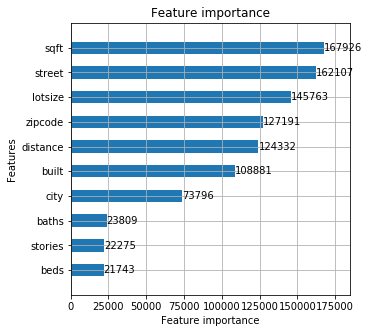

In [31]:
# Feature importance для LightGBM
fig =  plt.figure(figsize = (5,5))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();
plt.close()

In [32]:
# Dataframe со всеми метриками
models = pd.DataFrame({
    'Model': ['Random Forest', 'XGB', 'LGBM'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'mape_train': acc_train_mape,
    'mape_test': acc_test_mape,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [33]:
# Итоговый результат
print('Prediction accuracy for models by different metrics')
models.sort_values(by=['mape_test', 'mape_train'], ascending=False)

Prediction accuracy for models by different metrics


,Model,r2_train,r2_test,mape_train,mape_test,rmse_train,rmse_test
0,Random Forest,63.96,61.93,47.06,47.16,27807785.86,28345950.14
1,XGB,97.31,82.43,15.37,23.82,7595700.68,19256852.50
2,LGBM,96.99,83.43,4.95,22.53,8035831.81,18700275.19


In [34]:
# Предсказания
lgb_predict = modelL.predict(test0)

In [35]:
# Обработка и анализ результата
final_df = test_target0.values
final_df = pd.DataFrame(final_df,columns=['Real_price'])
for x in range(len(lgb_predict)):
    lgb_predict[x] = round(lgb_predict[x]/1000)*1000
final_df['predicted_prices'] = lgb_predict.astype(int)
final_df['difference'] = abs(final_df['Real_price'] - final_df['predicted_prices']).astype(int)
final_df.head(10)

,Real_price,predicted_prices,difference
0,240282,237000,3282
1,145000,183000,38000
2,634900,531000,103900
3,59000,372000,313000
4,885000,868000,17000
5,200000,193000,7000
6,219500,354000,134500
7,859000,830000,29000
8,1999000,1915000,84000
9,785000,839000,54000


In [37]:
# Сохранение модели
import pickle
with open('mymodel3.pkl', 'wb') as output:
       pickle.dump(modelL, output)